# Projet Calibration

### Théo MIDAVAINE & Matthieu JULIEN

In [1]:
import math
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random 
import math

In [2]:
S = 100
r = 0

In [43]:
def newton_raphson_implied_vol(row, S, r, initial_guess=0.2, T=1):     
    sigma = initial_guess     
    K = row['strikes']
    price_market = row['prices']  
    for _ in range(100):           
        d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        price_model = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)  
        vega = S * np.sqrt(T) * norm.pdf(d1)  
        price_diff = price_market - price_model  
        
        if np.abs(price_diff) < 1e-8:               
            return sigma                  
        sigma += price_diff / vega  # Mise à jour de sigma
        
        if sigma < 0:               
            sigma = 0.001     
    return sigma

def quadratic_interpolation(x_interpolated, x_original, y_original):
    y_interpolated = []
    for x in x_interpolated:
        for i in range(len(x_original) - 2):
            if x_original[i] <= x <= x_original[i + 2]:
                x1, x2, x3 = x_original[i], x_original[i + 1], x_original[i + 2]
                y1, y2, y3 = y_original[i], y_original[i + 1], y_original[i + 2]
                break

        A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [x3**2, x3, 1]])
        B = np.array([y1, y2, y3])
        a, b, c = np.linalg.solve(A, B)
        y = a*x**2 + b*x + c
        y_interpolated.append(y)

    return y_interpolated

def interpolation(data,T):
    prices = []
    #interpolation of vol
    x_original = np.array(data.index)
    y_original = np.array(data["implied_vol"])
 
    nb_pts = 100
    x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
    y_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)
 
    #interpolation of strikes
    x_original=data.index
    y_original=data["strikes"]
    x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
    strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)
 
    #Calcul des prix avec la formule de black scholes en fonction des paramêtres interpolés
    for i,j in zip(strike_interpolated,y_interpolated):
        prices.append(black_scholes_call_price(S,i,T,r,j))
   
    df=pd.DataFrame([prices,strike_interpolated,y_interpolated],index=["prices","strikes",'implied_vol']).T
    return df

In [71]:
data_12_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                'prices': [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]}
data_9_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                 'prices':[11.79 ,8.95 ,8.07 ,7.03 ,6.18 ,6.04 ,5.76 ,5.50 ,5.50 ,5.39]}
data_6_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                    'prices': [10.71 ,8.28 ,6.91 ,6.36 ,5.29 ,5.07 ,4.76 ,4.47 ,4.35 ,4.14]}
data_3_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                 'prices': [8.67, 7.14, 5.98, 4.93, 4.09, 3.99, 3.43, 3.01, 2.72, 2.53]}

df_12_months = pd.DataFrame(data_12_months)
df_9_months = pd.DataFrame(data_9_months)
df_6_months = pd.DataFrame(data_6_months)
df_3_months = pd.DataFrame(data_3_months)


# On utilise l'algorithme de Newton Raphson pour trouver les volatilités implicites

df_12_months["implied_vol"] = df_12_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 1), axis=1)
df_9_months["implied_vol"] = df_9_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 9/12), axis=1)
df_6_months["implied_vol"] = df_6_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 6/12), axis=1)
df_3_months["implied_vol"] = df_3_months.apply(lambda row: newton_raphson_implied_vol(row, S, r, 3/12), axis=1)

"""
df_12_months = interpolation(df_12_months,1)
df_9_months = interpolation(df_9_months,0.75)
df_6_months = interpolation(df_6_months,0.5)
df_3_months = interpolation(df_3_months,0.25)
""" 

df_12_months['maturity'] =  [1]*10
df_9_months['maturity'] = [0.75]*10
df_6_months['maturity'] = [0.5]*10
df_3_months['maturity'] = [0.25]*10


df_concatenated = pd.concat([df_12_months,df_9_months, df_6_months, df_3_months])
df_concatenated.reset_index(drop=True,inplace=True)

In [72]:
df_concatenated

,strikes,prices,implied_vol,maturity
0,95,10.93,0.210948,1.00
1,96,9.55,0.189023,1.00
2,97,8.28,0.170031,1.00
3,98,7.40,0.160956,1.00
4,99,6.86,0.160079,1.00
5,100,6.58,0.165124,1.00
6,101,6.52,0.175031,1.00
7,102,6.49,0.185098,1.00
8,103,6.47,0.194908,1.00
9,104,6.46,0.204530,1.00


4/ Calibrer un modèle à volatilité locale de type SVI en suivant les étapes suivantes : 
- écrire l’algorithme de valorisation d’une option avec le modèle SVI(stochastic volatility inspired), par EDP d’une part et par 
Monte Carlo d’autre part et comparer les résultats pour plusieurs jeux de paramètres ; 


##### voir slide 69 la formule pour le modèle SVI

In [254]:
param = [0.1] * 5

def svi_model(x, param):
    a,b,rho,m,sigma = param
    variance = a + b * (rho * (x - m) + np.sqrt((x - m)**2 + sigma**2))
    return np.sqrt(variance)

def forward_price_calculation(S0, r, T):
    return S0 * np.exp(r*T)

def log_moneyness_calculation(strike, forward_price):
    return np.log(strike/forward_price)

def valorisation_MC_SVI(S0, param, r, nb_simulations, pas, strike, maturity):
    dt = maturity / pas
    paths = np.zeros((nb_simulations, pas + 1))
    paths[:, 0] = S   

    for i in range(pas):
        forward_price = forward_price_calculation(S0, r, maturity)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol = svi_model(log_moneyness, param)  
        paths[:, i + 1] = paths[:, i] * np.exp((r - 0.5 * vol**2) * dt + np.sqrt(dt * vol**2) * np.random.normal(0, 1, size=nb_simulations))

    option_payoffs = np.maximum(paths[:, -1] - strike, 0)
    option_value = np.exp(-r * maturity) * np.mean(option_payoffs)  

    return option_value

for strike,market_price,maturity in zip(df_12_months["strikes"],df_12_months["prices"], df_12_months["maturity"]):
    option_price_mc_SVI = valorisation_MC_SVI(S, param, r, 1000, 252, strike, maturity)
    print(f"Prix par simulation de Monte Carlo pour K = {strike}: {option_price_mc_SVI:.2f}")
    print(f"Market Price = {market_price:.2f}, Difference = {abs(option_price_mc_SVI-market_price):.2f}")

Prix par simulation de Monte Carlo pour K = 95: 15.30
Market Price = 10.93, Difference = 4.37
Prix par simulation de Monte Carlo pour K = 96: 14.14
Market Price = 9.55, Difference = 4.59
Prix par simulation de Monte Carlo pour K = 97: 15.60
Market Price = 8.28, Difference = 7.32
Prix par simulation de Monte Carlo pour K = 98: 14.31
Market Price = 7.40, Difference = 6.91
Prix par simulation de Monte Carlo pour K = 99: 14.31
Market Price = 6.86, Difference = 7.45
Prix par simulation de Monte Carlo pour K = 100: 12.76
Market Price = 6.58, Difference = 6.18
Prix par simulation de Monte Carlo pour K = 101: 13.08
Market Price = 6.52, Difference = 6.56
Prix par simulation de Monte Carlo pour K = 102: 13.29
Market Price = 6.49, Difference = 6.80
Prix par simulation de Monte Carlo pour K = 103: 12.78
Market Price = 6.47, Difference = 6.31
Prix par simulation de Monte Carlo pour K = 104: 12.01
Market Price = 6.46, Difference = 5.55


- estimez les cinq paramètres permettant de réduire au plus l’erreur moyenne ; 


In [256]:
def cost_function_SVI(param, strikes, vols_market,maturity):
    vols_model = []
    for strike in strikes : 
        forward_price = forward_price_calculation(S, r, maturity)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vols_model.append(svi_model(log_moneyness, param))
    return np.sum((vols_model - vols_market) ** 2)

strikes_12m = df_12_months["strikes"]
vols_market_12m = df_12_months["implied_vol"]
initial_params = [0.1]*5
initial_params_12m = [0.1,0.6]+[0.1]*3

bounds = [(0, None),  # a >= 0
          (0, None),  # b >= 0
          (None,None ),    # -1 <= rho <= 1   since rho is a correlation parameter
          (None, None),  # No specific bounds for m
          (None, None)]  # sigma >= 0
bounds_12m = [(0, None),  # a >= 0
          (0.6, None),  # b >= 0
          (None,None ),    # -1 <= rho <= 1   since rho is a correlation parameter
          (None, None),  # No specific bounds for m
          (None, None)]  # sigma >= 0

result_12m = minimize(cost_function_SVI, initial_params_12m, args=(strikes_12m, vols_market_12m, 1), method='Nelder-Mead', bounds=bounds_12m)
calibrated_params_12m = result_12m.x
print("Paramètres calibrés 12m:", calibrated_params_12m)


Paramètres calibrés 12m: [ 0.01698204  0.60007716 -0.3420817  -0.02037805 -0.0141863 ]


On teste la valorisation des options 12 mois et comparons à nos vraies valeurs de marché.
Pour le set de paramètres nous utilisons celui déterminé dans la suite du projet, qui minimise l'erreur moyenne.

In [257]:
# Paramètres du modèle SVI 
calibrated_params = calibrated_params_12m
pas=252
diff_totale=0
opt = []
for strike,market_price,maturity in zip(df_12_months["strikes"],df_12_months["prices"], df_12_months["maturity"]):
    option_price_mc_SVI = valorisation_MC_SVI(S, calibrated_params, r, 1000, 252, strike, maturity)
    print(f"Prix par simulation de Monte Carlo pour K = {strike}: {option_price_mc_SVI:.2f}")
    print(f"Market Price = {market_price:.2f}, Difference = {abs(option_price_mc_SVI-market_price):.2f}")
    opt.append(option_price_mc_SVI)
    diff_totale+=abs(option_price_mc_SVI-market_price)
print(diff_totale)

Prix par simulation de Monte Carlo pour K = 95: 10.51
Market Price = 10.93, Difference = 0.42
Prix par simulation de Monte Carlo pour K = 96: 9.99
Market Price = 9.55, Difference = 0.44
Prix par simulation de Monte Carlo pour K = 97: 8.36
Market Price = 8.28, Difference = 0.08
Prix par simulation de Monte Carlo pour K = 98: 7.07
Market Price = 7.40, Difference = 0.33
Prix par simulation de Monte Carlo pour K = 99: 7.03
Market Price = 6.86, Difference = 0.17
Prix par simulation de Monte Carlo pour K = 100: 6.32
Market Price = 6.58, Difference = 0.26
Prix par simulation de Monte Carlo pour K = 101: 6.51
Market Price = 6.52, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 102: 6.45
Market Price = 6.49, Difference = 0.04
Prix par simulation de Monte Carlo pour K = 103: 6.31
Market Price = 6.47, Difference = 0.16
Prix par simulation de Monte Carlo pour K = 104: 6.93
Market Price = 6.46, Difference = 0.47
2.374181349490118


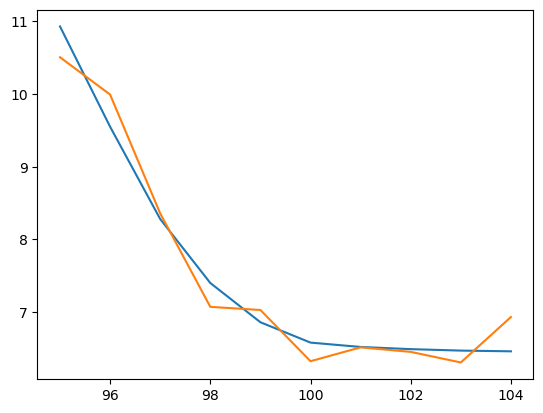

In [258]:
plt.plot(strikes_12m,df_12_months['prices'])
plt.plot(strikes_12m,opt)

Notre algorithme de valorisation par Monte Carlo nous donne des prix proches

In [259]:
def cost_function_SVI(param, strikes, vols_market,maturity):
    vols_model = []
    for strike in strikes : 
        forward_price = forward_price_calculation(S, r, maturity)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vols_model.append(svi_model(log_moneyness, param))
    return np.sum((vols_model - vols_market) ** 2)

# Données de marché
strikes_12m = df_12_months["strikes"]
vols_market_12m = df_12_months["implied_vol"]
strikes_9m = df_9_months["strikes"]
vols_market_9m = df_9_months["implied_vol"]
strikes_6m = df_6_months["strikes"]
vols_market_6m = df_6_months["implied_vol"]
strikes_3m = df_12_months["strikes"]
vols_market_3m = df_3_months["implied_vol"]

# Initialisation des paramètres
initial_params = [0.1]*5

# Minimisation de la fonction de coût
result_12m = minimize(cost_function_SVI, initial_params_12m, args=(strikes_12m, vols_market_12m,1), method='Nelder-Mead', bounds=bounds_12m)
result_9m = minimize(cost_function_SVI, initial_params, args=(strikes_9m, vols_market_9m,0.75), method='Nelder-Mead',tol=0, bounds=bounds)
result_6m = minimize(cost_function_SVI, initial_params, args=(strikes_6m, vols_market_6m,0.5), method='Nelder-Mead',tol=0, bounds=bounds)
result_3m = minimize(cost_function_SVI, initial_params, args=(strikes_3m, vols_market_3m,0.25), method='Nelder-Mead',tol=0, bounds=bounds)

# Paramètres calibrés
calibrated_params_12m = result_12m.x
calibrated_params_9m = result_9m.x
calibrated_params_6m = result_6m.x
calibrated_params_3m = result_3m.x

# Affichage des résulta
print("Paramètres calibrés 12m:", calibrated_params_12m)
print("Paramètres calibrés 9m:", calibrated_params_9m)
print("Paramètres calibrés 6m:", calibrated_params_6m)
print("Paramètres calibrés 3m:", calibrated_params_3m)

Paramètres calibrés 12m: [ 0.01698204  0.60007716 -0.3420817  -0.02037805 -0.0141863 ]
Paramètres calibrés 9m: [ 0.          1.13298628 -0.65940348 -0.03224054  0.02410595]
Paramètres calibrés 6m: [ 0.0040773   1.58841627 -0.88960153 -0.04432398 -0.01599542]
Paramètres calibrés 3m: [ 0.          0.6900634  -0.8528763  -0.04342295  0.02477059]


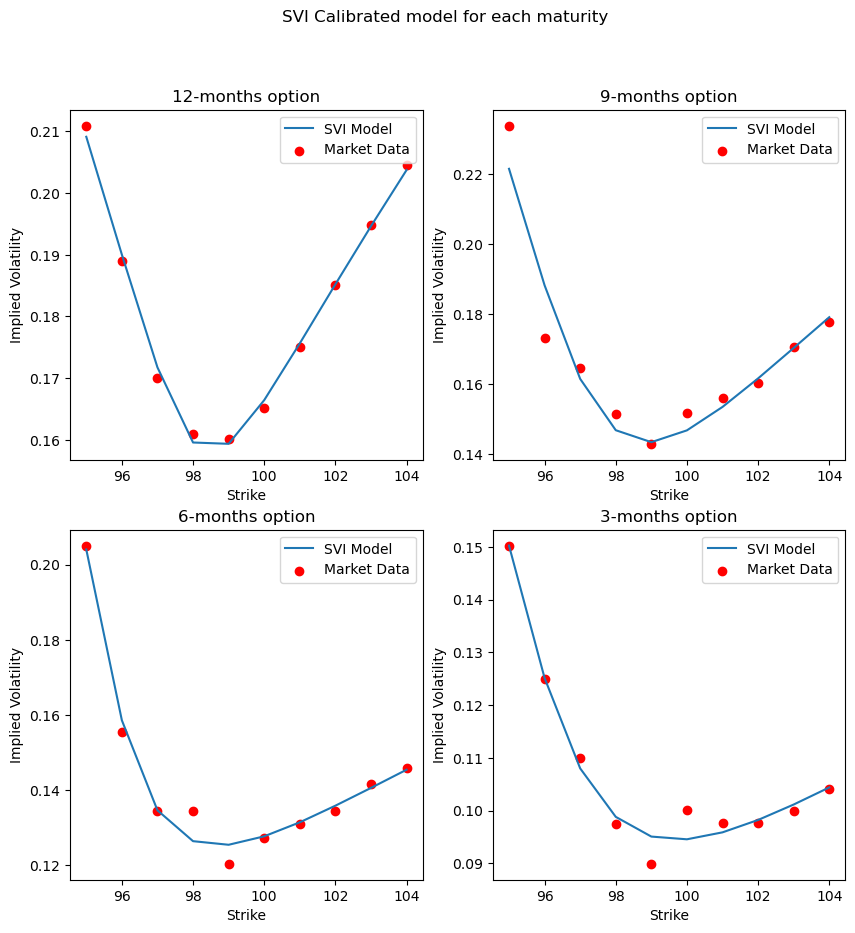

In [261]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,10))
fig.suptitle('SVI Calibrated model for each maturity')

# Visualisation de la surface de volatilité implicite
strikes_plot_12m = np.linspace(min(strikes_12m), max(strikes_12m), 10)
vols_plot_12m =[] 
for strike in strikes_plot_12m : 
    forward_price = forward_price_calculation(S, r, 1)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_12m.append(svi_model(log_moneyness, calibrated_params_12m))

ax1.plot(strikes_plot_12m, vols_plot_12m, label='SVI Model')
ax1.scatter(strikes_12m, vols_market_12m, color='red', label='Market Data')
ax1.set_xlabel('Strike')
ax1.set_ylabel('Implied Volatility')
ax1.set_title("12-months option")
ax1.legend()

strikes_plot_9m = np.linspace(min(strikes_9m), max(strikes_9m), 10)
vols_plot_9m =[] 
for strike in strikes_plot_9m : 
    forward_price = forward_price_calculation(S, r, 0.75)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_9m.append(svi_model(log_moneyness, calibrated_params_9m))

ax2.plot(strikes_plot_9m, vols_plot_9m, label='SVI Model')
ax2.scatter(strikes_9m, vols_market_9m, color='red', label='Market Data')
ax2.set_xlabel('Strike')
ax2.set_ylabel('Implied Volatility')
ax2.set_title("9-months option")
ax2.legend()

strikes_plot_6m = np.linspace(min(strikes_6m), max(strikes_6m), 10)
vols_plot_6m =[] 
for strike in strikes_plot_6m : 
    forward_price = forward_price_calculation(S, r, 0.5)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_6m.append(svi_model(log_moneyness, calibrated_params_6m))

ax3.plot(strikes_plot_6m, vols_plot_6m, label='SVI Model')
ax3.scatter(strikes_6m, vols_market_6m, color='red', label='Market Data')
ax3.set_xlabel('Strike')
ax3.set_ylabel('Implied Volatility')
ax3.set_title("6-months option")
ax3.legend()

strikes_plot_3m = np.linspace(min(strikes_3m), max(strikes_3m), 10)
vols_plot_3m =[] 
for strike in strikes_plot_3m : 
    forward_price = forward_price_calculation(S, r, 0.25)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_3m.append(svi_model(log_moneyness, calibrated_params_3m))

ax4.plot(strikes_plot_3m, vols_plot_3m, label='SVI Model')
ax4.scatter(strikes_3m, vols_market_3m, color='red', label='Market Data')
ax4.set_xlabel('Strike')
ax4.set_ylabel('Implied Volatility')
ax4.set_title("3-months option")
ax4.legend()

plt.show()


- on fixe tous les paramètres aux valeurs estimées ci-avant (sauf a et b) et on va calibrer les deux 
paramètres a et b pour chaque option : vous obtiendrez donc une nappe pour chacun de ces 
deux paramètres et vous introduirez une contrainte de régularisation de ces deux nappes dans 
votre problème d’optimisation. 

In [262]:
calibrated_params_concat = [calibrated_params_12m]+[calibrated_params_9m]+[calibrated_params_6m]+[calibrated_params_3m]

In [350]:
def svi_fixed(param, calibrated_params,x):
    a, b = param
    rho, m, sigma = calibrated_params[2:5]
    variance = a + b * (rho * (x - m) + np.sqrt((x - m)**2 + sigma**2))
    return np.sqrt(variance)
 
# Liste des options et des prix du marché
strikes = df_concatenated["strikes"]
maturities = df_concatenated['maturity']
market_prices = df_concatenated["prices"]
vol_market= df_concatenated["implied_vol"]
 
# Fonction d'erreur pour l'optimisation
def cost_function_SVI_fixed(param, calibrated_params, strike, vols_market,maturity):
    forward_price = forward_price_calculation(S, r, maturity)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_model = svi_fixed(param, calibrated_params,log_moneyness)
    return np.sum((vols_model - vols_market) ** 2)

bounds_ab = [(0, None),  # a >= 0
          (None, None)] # b >= 0

# Estimation des paramètres a et b pour chaque option
a_values = []
b_values = []
i = 0
"""
for k,sigma in zip(strikes, df_12_months['implied_vol']):
    res_12m = minimize(cost_function_SVI, [0.1, 0.1], args=(calibrated_params_concat[0], k, sigma,1), bounds=bounds_ab)
    a_12m, b_12m = res_12m.x
    a_values.append(a_12m)
    b_values.append(b_12m)
for k,sigma in zip(strikes, df_9_months['implied_vol']):
    res_9m = minimize(cost_function_SVI, [0.1, 0.1], args=(calibrated_params_concat[1], k, sigma,0.75), bounds=bounds_ab)
    a_9m, b_9m = res_9m.x
    a_values.append(a_9m)
    b_values.append(b_9m)

for k,sigma in zip(strikes, df_6_months['implied_vol']):
    res_6m = minimize(cost_function_SVI, [0.1, 0.1], args=(calibrated_params_concat[2], k, sigma,0.5), bounds=bounds_ab)
    a_6m, b_6m = res_6m.x
    a_values.append(a_6m)
    b_values.append(b_6m)

for k,sigma in zip(strikes, df_3_months['implied_vol']):
    res_3m = minimize(cost_function_SVI, [0.1, 0.1], args=(calibrated_params_concat[0], k, sigma,0.25), bounds=bounds_ab)
    a_3m, b_3m = res.x
    a_values.append(a_3m)
    b_values.append(b_3m)
    
"""
for k, sigma in zip(strikes,vol_market):
    print(k)
    print(sigma)
    print(1-0.25*i)
    if k == 104.0 and i < 3:
        i += 1
    res = minimize(cost_function_SVI_fixed, [0., 0.], args=(calibrated_params_concat[i], k, sigma,(1-0.25*i)), bounds=bounds_ab,method='Nelder-mead')
    print(res)
    a, b = res.x
    a_values.append(a)
    b_values.append(b)


95
0.21094792526519204
1.0
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.2617275190554452e-09
             x: [ 4.414e-02  8.367e-03]
           nit: 25
          nfev: 49
 final_simplex: (array([[ 4.414e-02,  8.367e-03],
                       [ 4.409e-02,  8.341e-03],
                       [ 4.407e-02,  8.411e-03]]), array([ 1.262e-09,  6.192e-09,  1.619e-08]))
96
0.18902307570533544
1.0
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 6.688853635576578e-12
             x: [ 3.551e-02  6.754e-03]
           nit: 31
          nfev: 59
 final_simplex: (array([[ 3.551e-02,  6.754e-03],
                       [ 3.551e-02,  6.825e-03],
                       [ 3.551e-02,  6.805e-03]]), array([ 6.689e-12,  1.573e-11,  3.057e-11]))
97
0.1700311927126478
1.0
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 5.291415479109221e-10
             x: [ 3.146e-02  6.289e-03]
           nit: 23
          nfev: 45
 final_simplex: (array([[ 3.146e-02,  6.289e-03],
                       [ 3.140e-02,  6.230e-03],
                       [ 3.138e-02,  6.335e-03]]), array([ 5.291e-10,  2.284e-08,  4.575e-08]))
95
0.20508376428931327
0.5
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.791541564493306e-13
             x: [ 4.187e-02  8.112e-03]
           nit: 34
          nfev: 63
 final_simplex: (array([[ 4.187e-02,  8.112e-03],
                       [ 4.187e-02,  8.076e-03],
                       [ 4.187e-02,  8.209e-03]]), array([ 1.792e-13,  3.055e-12,  3.952e-12]))
96
0.15547363291747937
0.5
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2.7343248868730116e-12
      

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.1151630518935272e-10
             x: [ 1.080e-02  2.294e-03]
           nit: 23
          nfev: 44
 final_simplex: (array([[ 1.080e-02,  2.294e-03],
                       [ 1.079e-02,  2.343e-03],
                       [ 1.079e-02,  2.196e-03]]), array([ 1.115e-10,  4.048e-10,  5.675e-10]))


In [349]:
def svi_fixed(param, calibrated_params,x):
    a, b = param
    rho, m, sigma = calibrated_params[2:5]
    variance = a + b * (rho * (x - m) + np.sqrt((x - m)**2 + sigma**2))
    return a,b,np.sqrt(variance)
 
# Liste des options et des prix du marché
strikes = df_concatenated["strikes"]
maturities = df_concatenated['maturity']
market_prices = df_concatenated["prices"]
vol_market= df_concatenated["implied_vol"]
 
# Fonction d'erreur pour l'optimisation
def cost_function_SVI_fixed(param, calibrated_params, strike, vols_market,maturity):
    vols_model = []
    for strike in strikes : 
        forward_price = forward_price_calculation(S, r, maturity)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        a,b,vol = svi_fixed(param, calibrated_params,log_moneyness)
        a_values.append(a)
        b_values.append(b)
        vols_model.append(vol)
    return np.sum((vols_model - vols_market) ** 2)

bounds_ab = [(0, None),  # a >= 0
          (None, None)] # b >= 0

# Estimation des paramètres a et b pour chaque option
a_values = []
b_values = []
i = 0

for k, sigma,maturity in zip(strikes,vol_market,maturities):
    minimize(cost_function_SVI_fixed, [0.1, 0.1], args=(calibrated_params_concat[i], k, sigma,maturity), bounds=bounds_ab,method='Nelder-Mead')



TypeError: unsupported operand type(s) for -: 'list' and 'float'

In [351]:
b_values

[0.008367299322737392,
 0.00675433809275274,
 0.005559211730957036,
 0.004605964501679415,
 0.004937238686019557,
 0.0047628049865306886,
 0.005630419540219015,
 0.006692219106247656,
 0.007431935757398614,
 0.008353606329532347,
 0.010364128867623106,
 0.005724275588989263,
 0.005257869102410045,
 0.0038979567289352457,
 0.003607144197449091,
 0.003967786073684696,
 0.004276646390557293,
 0.004607665671035652,
 0.005715029716491703,
 0.006289366561453794,
 0.008111688499055171,
 0.004028934214264158,
 0.003329772693105045,
 0.0031918182009831107,
 0.002727220907807353,
 0.0032578677386045484,
 0.003145507812500003,
 0.0031595986935426513,
 0.0037945196777582207,
 0.0035125923398882175,
 0.004129476333502684,
 0.0035664735874161146,
 0.002435353726148607,
 0.0019442362487316143,
 0.001298988342285157,
 0.0020730633735656753,
 0.0018401138186454787,
 0.0018401138186454787,
 0.0019735660552978535,
 0.00229443144798279]

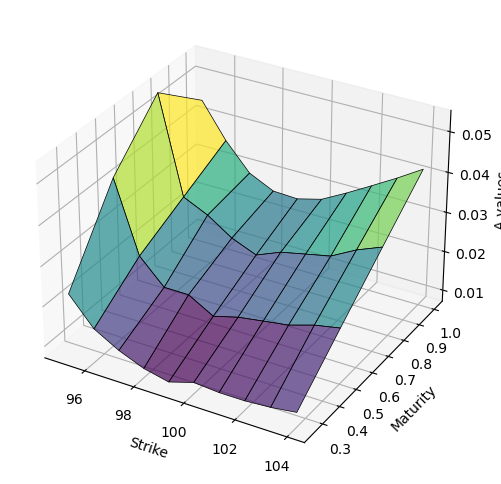

In [352]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Utilisation de plot_surface pour créer une surface 3D
ax.plot_surface(np.array(strikes).reshape(4,-1), 
                np.array(maturities).reshape(4,-1),
                np.array(a_values).reshape(4,-1), 
                cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.7)

# Configurations supplémentaires
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('A values')

# Affichage de la figure
plt.show()

A voir si on utilise les valeurs interpolées

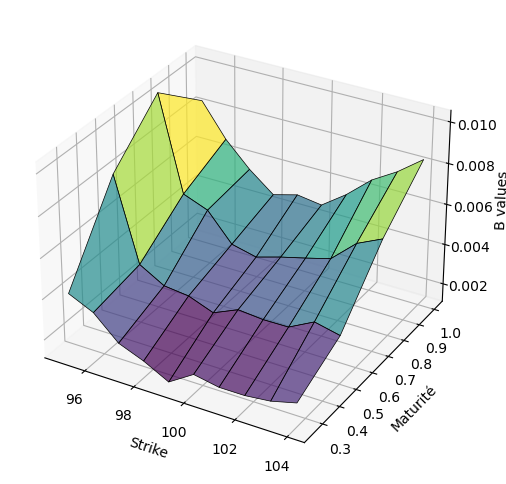

In [353]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(np.array(strikes).reshape(4,-1),
                np.array(maturities).reshape(4,-1),
                np.array(b_values).reshape(4,-1), 
                cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.7)
# Configurations supplémentaires
ax.set_xlabel('Strike')
ax.set_ylabel('Maturité')
ax.set_zlabel('B values')
# Affichage de la figure
plt.show()

In [296]:
b_values

[0.09077772377864803,
 0.09118670460118865,
 0.09287609537789927,
 0.09466653070915511,
 0.0946536769356567,
 0.09355442529394227,
 0.0925189125057259,
 0.09100055500171918,
 0.09105244419493906,
 0.09074166814531792,
 0.09409341597806534,
 0.08836335748854536,
 0.09157563845870297,
 0.09192395788487594,
 0.09152594918741587,
 0.09193441502774741,
 0.09159991990950339,
 0.09111277696416548,
 0.09123861598162014,
 0.09013450296924214,
 0.09489060541952249,
 0.09466216568585566,
 0.09550847046943098,
 0.09619530300012696,
 0.09568225576467812,
 0.09578132674760474,
 0.09562303089073527,
 0.0954038682509248,
 0.09535784565680153,
 0.09517926772009104,
 0.08885888734176474,
 0.08885888734176474,
 0.08885888734176474,
 0.08885888734176474,
 0.08885888734176474,
 0.08885888734176474,
 0.08885888734176474,
 0.08885888734176474,
 0.08885888734176474,
 0.08885888734176474]

5/ En utilisant les nappes obtenues pour le modèle SVI (à la dernière étape), proposer encore un prix, 
le plus juste possible, pour une option de strike 99.50 et de maturité 8 mois (justifier la méthode 
retenue). 

In [354]:
df_concatenated['a_values'] = a_values
df_concatenated['b_values'] = b_values

Brouillon explication : 

interpolation de a values pour 99.5/8M interpolation de b values pour 99.5/8M

imp vol svi = svi (param [a_inter,b_inter,calibrated param])

BS(K,t,imp vol svi)


TEST DU MODEL DE BILINEARITE

In [355]:
def bilinear_interpolation(x, y, points):
    
# Fvoir sur https ://fr.wikipedia.org/wiki/Interpolation_bilin%C3%A9aire
    points = sorted(points)
    (x1 , y1 , q11), (_x1 , y2, q12), (x2, _y1 , q21), (_x2 , _y2 , q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError("points do not form a rectangle")
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError("(x, y) not within the rectangle ")

    return (q11 * (x2 - x) * (y2 - y) +
    q21 * (x - x1) * (y2 - y) +
    q12 * (x2 - x) * (y - y1) +
    q22 * (x - x1) * (y - y1)) / ((x2 - x1) * (y2 - y1) + 0.0)

In [356]:
x_val = 99
y_val = 1
z_val = bilinear_interpolation(x_val,y_val,[(98,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 98)]['a_values'].values)),
                                            (98,1,float(df_concatenated[(df_concatenated['maturity'] == 1) & (df_concatenated['strikes'] == 98)]['a_values'].values)),
                                        (99,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 99)]['a_values'].values)),
                                        (99,1,float(df_concatenated[(df_concatenated['maturity'] == 1) & (df_concatenated['strikes'] == 99)]['a_values'].values))
                                        ]                 
                               )
z2_val = bilinear_interpolation(x_val,y_val,[(98,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 98)]['b_values'].values)),
                                            (98,1,float(df_concatenated[(df_concatenated['maturity'] == 1) & (df_concatenated['strikes'] == 98)]['b_values'].values)),
                                        (99,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 99)]['b_values'].values)),
                                        (99,1,float(df_concatenated[(df_concatenated['maturity'] == 1) & (df_concatenated['strikes'] == 99)]['b_values'].values))
                                        ]                 
                               )

On teste l'interpolation pour les a et b values du modèle svi, avec des données que l'on connait déjà pour voir si le modèle nous sort des prix cohérents 

In [367]:
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [366]:
forward_price = forward_price_calculation(S, r, 1)
log_moneyness = log_moneyness_calculation(99, forward_price)
test_imp = svi_model(log_moneyness, calibrated_params_concat[0])
price = black_scholes_call_price(100,99,1,0,test_imp)
price

6.831136555694542

Vrai prix

In [359]:
float(df_concatenated[(df_concatenated['maturity'] == 1) & (df_concatenated['strikes'] == 99)]['prices'].values)

6.86

Voir diff entre true value et model value

In [383]:
x_val = 99.5
y_val = 8/12
a_val = bilinear_interpolation(x_val,y_val,[(99,0.5,float(df_concatenated[(df_concatenated['maturity'] == 0.5) & (df_concatenated['strikes'] == 99)]['a_values'].values)),
                                            (99,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 99)]['a_values'].values)),
                                        (100,0.5,float(df_concatenated[(df_concatenated['maturity'] == 0.5) & (df_concatenated['strikes'] == 100)]['a_values'].values)),
                                        (100,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 100)]['a_values'].values))
                                        ]                 
                               )
b_val = bilinear_interpolation(x_val,y_val,[(99,0.5,float(df_concatenated[(df_concatenated['maturity'] == 0.5) & (df_concatenated['strikes'] == 99)]['b_values'].values)),
                                            (99,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 99)]['b_values'].values)),
                                        (100,0.5,float(df_concatenated[(df_concatenated['maturity'] == 0.5) & (df_concatenated['strikes'] == 100)]['b_values'].values)),
                                        (100,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 100)]['b_values'].values))
                                        ]                 
                               )

In [384]:
def linear_interpolation(x0, y0, x1, y1, x):
    slope = (y1 - y0) / (x1 - x0)
    y = y0 + slope * (x - x0)
    return y

In [385]:
rho_8m = linear_interpolation(6,calibrated_params_concat[2][2],9,calibrated_params_concat[1][2],8)
m_8m = linear_interpolation(6,calibrated_params_concat[2][3],9,calibrated_params_concat[1][3],8)
sigma_8m = linear_interpolation(6,calibrated_params_concat[2][4],9,calibrated_params_concat[1][4],8)

voir si on douille le prof avec les paramètres du 3 mois plutot que le 9 mois

In [ ]:
def svi_fixed(param, calibrated_params,x):
    a, b = param
    rho, m, sigma = calibrated_params[2:5]
    variance = a + b * (rho * (x - m) + np.sqrt((x - m)**2 + sigma**2))
    return np.sqrt(variance)

In [386]:
imp_vol_svi_8 = svi_fixed([a_val,b_val],calibrated_params_concat[3],99.5) #Calibrated param for 6 months

In [387]:
imp_vol_svi_8_inter = svi_fixed([a_val,b_val],[0,0,rho_8m,m_8m,sigma_8m],99.5) #Calibrated param for 6 months

In [388]:
imp_vol_svi_8_inter

0.33470560467978305

In [ ]:
forward_price = forward_price_calculation(S, r, 1)
log_moneyness = log_moneyness_calculation(99.5, forward_price)
test_imp = svi_fixed(, calibrated_params_concat[0])
price = black_scholes_call_price(100,99,1,0,test_imp)
price

In [391]:
forward_price = forward_price_calculation(S, r, 1)
log_moneyness = log_moneyness_calculation(99.5, forward_price)
imp_vol_svi_8 = svi_fixed([a_val,b_val],calibrated_params_concat[3],log_moneyness)
price_svi = black_scholes_call_price(100,99.5,8/12,0,imp_vol_svi_8)
print(f"Prix trouvé avec l'interpolation bilinéaire et param pour 9 mois : {price_svi:.4f}")
forward_price_int = forward_price_calculation(S, r, 1)
log_moneyness_int = log_moneyness_calculation(99.5, forward_price_int)
imp_vol_svi_8_int = svi_fixed([a_val,b_val],[0,0,rho_8m,m_8m,sigma_8m],log_moneyness_int)
price_svi_inter = black_scholes_call_price(100,99.5,8/12,0,imp_vol_svi_8_int)
print(f"Prix trouvé avec l'interpolation bilinéaire de a et b et autres params interpolés pour 8 mois : {price_svi_inter:.4f}")

Prix trouvé avec l'interpolation bilinéaire et param pour 9 mois : 4.7960
Prix trouvé avec l'interpolation bilinéaire de a et b et autres params interpolés pour 8 mois : 4.7948


4.7066

Justifier notre méthode choisie

6/ écrire l’algorithme de valorisation d’une option avec le modèle PDV, par Monte Carlo (les seuls 
rendements considérés seront ceux simulés entre la date courante et la maturité) ; 

